# Image Classification from scratch with TPUs on Cloud ML Engine using ResNet

This notebook demonstrates how to do image classification from scratch on a flowers dataset using TPUs and the resnet trainer.

A detailed Tutorial can be find under the following Link:

https://medium.com/p/c71b6eed78e0/edit

-----------------------------------------------------

### 0) Project Sttings

In the next Step we have to set some important Settings:

In [31]:
import os

GC_PROJECT ='bq-mak-yourhome'             # REPLACE WITH YOUR GOOGLE PROJECT ID
BUCKET = 'product-classification'         # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1'                    # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
PROJECT = 'project_001_freisteller'       # REPLACE WITH YOUR <YOUR_PROJECT_NAME>
MODEL_VERSION = 'ResNet_v03'              # REPLACE WITH A MODEL NAME eg. ResNet_v01


# do not change these
os.environ['GC_PROJECT'] = GC_PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['PROJECT'] = PROJECT
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TFVERSION'] = '1.14'


In [32]:
%%bash
gcloud config set project $GC_PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


---------------------------------------------------------

### 1) Mounting Bucket

The Notebook will need Access to the created Bucket in the GCS

this will be achived by mounting the bucket to the the Folder /home/jupyter/<YOUR_PROJECT_NAME> (the top Folder of the notebook) 

In [29]:
!fusermount -u /home/jupyter/$BUCKET

In [30]:
!/usr/bin/gcsfuse $BUCKET /home/jupyter/$BUCKET

Using mount point: /home/jupyter/product-classification
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


----------------------------------------

### 2) Enable TPU service account

Allow Cloud ML Engine to access the TPU and bill to your project

In [33]:
%%bash
SVC_ACCOUNT=$(curl -H "Authorization: Bearer $(gcloud auth print-access-token)"  \
    https://ml.googleapis.com/v1/projects/${GC_PROJECT}:getConfig \
              | grep tpuServiceAccount | tr '"' ' ' | awk '{print $3}' )
              
echo "Enabling TPU service account $SVC_ACCOUNT to act as Cloud ML Service Agent"
gcloud projects add-iam-policy-binding $GC_PROJECT --member serviceAccount:$SVC_ACCOUNT --role roles/ml.serviceAgent



Enabling TPU service account service-1048362755780@cloud-tpu.iam.gserviceaccount.com to act as Cloud ML Service Agent
bindings:
- members:
  - serviceAccount:bi-mak@bq-mak-yourhome.iam.gserviceaccount.com
  role: roles/bigquery.admin
- members:
  - serviceAccount:cnouch-oghub@bq-mak-yourhome.iam.gserviceaccount.com
  - serviceAccount:neckermann-oghub@bq-mak-yourhome.iam.gserviceaccount.com
  - serviceAccount:schlafwelt-oghub@bq-mak-yourhome.iam.gserviceaccount.com
  - serviceAccount:yourhome-oghub@bq-mak-yourhome.iam.gserviceaccount.com
  role: roles/bigquery.dataEditor
- members:
  - user:Natallia.Hamanovich@gmail.com
  - user:mbusch.otto@gmail.com
  - user:nhamanov.bi.otto@gmail.com
  role: roles/bigquery.dataOwner
- members:
  - user:evgeni.nikotto@gmail.com
  - user:neckermann.de1@gmail.com
  - user:uarndt93@gmail.com
  role: roles/bigquery.dataViewer
- members:
  - group:bqdts-prod-272293946235@bqdts.google.baggins
  role: roles/bigquery.jobUser
- members:
  - user:Heiner.Hippke@g

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   237    0   237    0     0    540      0 --:--:-- --:--:-- --:--:--   539
Updated IAM policy for project [bq-mak-yourhome].


----------------------------------------------------------------------

### 3) Preprocessing

#### 3.1) Local Preprocessing

We will need an empty Folder for our local Test:

In [34]:
!rm -r ${PWD}/local_test/*

For our local test we copy the first 5 Lines to a file in our local Test Folder

Furthermore we will need the labels.txt file from the GC Storage

In [7]:
%%bash
gsutil cat gs://${BUCKET}/${PROJECT}/train_set.csv | head -5 > ${PWD}/local_test/input.csv
gsutil cat gs://${BUCKET}/${PROJECT}/labels.txt > ${PWD}/local_test/labels.txt

No we will start the 

In [8]:
%%bash
export PYTHONPATH=${PYTHONPATH}:${PWD}/mymodel

python -m trainer.preprocess \
       --train_csv ${PWD}/local_test/input.csv \
       --validation_csv ${PWD}/local_test/input.csv \
       --labels_file ${PWD}/local_test/labels.txt \
       --project_id $PROJECT \
       --output_dir ${PWD}/local_test/out \
       --runner=DirectRunner

Read in 6 labels, from Zweifarbig to Sonstige


/home/jupyter/.local/lib/python2.7/site-packages/apache_beam/__init__.py:84: UserWarning: You are using Apache Beam with Python 2. New releases of Apache Beam will soon support Python 3 only.
  'You are using Apache Beam with Python 2. '
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Use tf.gfile.GFile.


2020-03-02 12:18:34.408145: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-03-02 12:18:35.023971: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-03-02 12:18:35.024225: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f49ec438a00 executing computations on platform Host. Devices:
2020-03-02 12:18:35.024250: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>




In [35]:
!ls -l ${PWD}/local_test/out

ls: cannot access '/home/jupyter/project_001_freisteller/local_test/out': No such file or directory


#### 3.2) Online Preprocessing

After we successfully created the small local Datasets, we will preprocess all our Data.

To speed this step up, we will run the Preprocessing with Googles dataflow

In [10]:
%%bash
export PYTHONPATH=${PYTHONPATH}:${PWD}/mymodel
    
gsutil -m rm -rf gs://${BUCKET}/resnet/data
python -m trainer.preprocess \
       --train_csv gs://${BUCKET}/${PROJECT}/train_set.csv \
       --validation_csv gs://${BUCKET}/${PROJECT}/eval_set.csv \
       --labels_file gs://${BUCKET}/${PROJECT}/labels.txt \
       --project_id $GC_PROJECT \
       --output_dir gs://${BUCKET}/${PROJECT}/resnet/data

Read in 6 labels, from Zweifarbig to Sonstige


CommandException: 1 files/objects could not be removed.
/home/jupyter/.local/lib/python2.7/site-packages/apache_beam/__init__.py:84: UserWarning: You are using Apache Beam with Python 2. New releases of Apache Beam will soon support Python 3 only.
  'You are using Apache Beam with Python 2. '
Removing gs://product-classification/project_001_freisteller/resnet/data/tmp/preprocess-images-191114-144527.1573742730.962885/#1573742751025572...
Removing gs://product-classification/project_001_freisteller/resnet/data/tmp/staging/preprocess-images-191114-144527.1573742730.962885/apache_beam-2.16.0-cp27-cp27mu-manylinux1_x86_64.whl#1573742739000400...
Removing gs://product-classification/project_001_freisteller/resnet/data/tmp/staging/preprocess-images-191114-144527.1573742730.962885/dataflow_python_sdk.tar#1573742736060944...
Removing gs://product-classification/project_001_freisteller/resnet/data/tmp/staging/preprocess-images-191114-144527.1573742730.962885/pickled_main_session#157374273280427

You will see the progress under the follwoing link:

https://console.cloud.google.com/dataflow

After the Preprocessing is done, you will see the created Train and Validataion Datasets with the following command:

In [11]:
%%bash
gsutil ls gs://${BUCKET}/${PROJECT}/resnet/data

gs://product-classification/project_001_freisteller/resnet/data/train-00000-of-00005
gs://product-classification/project_001_freisteller/resnet/data/train-00001-of-00005
gs://product-classification/project_001_freisteller/resnet/data/train-00002-of-00005
gs://product-classification/project_001_freisteller/resnet/data/train-00003-of-00005
gs://product-classification/project_001_freisteller/resnet/data/train-00004-of-00005
gs://product-classification/project_001_freisteller/resnet/data/validation-00000-of-00004
gs://product-classification/project_001_freisteller/resnet/data/validation-00001-of-00004
gs://product-classification/project_001_freisteller/resnet/data/validation-00002-of-00004
gs://product-classification/project_001_freisteller/resnet/data/validation-00003-of-00004
gs://product-classification/project_001_freisteller/resnet/data/tmp/


--------------------------------------------------------------------------------

### 4) Train on the Cloud

In [12]:
%%bash
echo -n "--num_train_images=$(gsutil cat gs://${BUCKET}/${PROJECT}/train_set.csv | wc -l)  "
echo -n "--num_eval_images=$(gsutil cat gs://${BUCKET}/${PROJECT}/eval_set.csv | wc -l)  "
echo "--num_label_classes=$(gsutil cat gs://${BUCKET}/${PROJECT}/labels.txt | wc -l)"

--num_train_images=865  --num_eval_images=94  --num_label_classes=6


In [43]:
%%bash
TOPDIR=gs://${BUCKET}/${PROJECT}/resnet
OUTDIR=${TOPDIR}/trained
JOBNAME=imgclass_$(date -u +%y%m%d_%H%M%S)


echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR  # Comment out this line to continue training from the last time

gcloud ai-platform jobs submit training $JOBNAME \
 --region=$REGION \
 --module-name=trainer.resnet_main \
 --package-path=$(pwd)/mymodel/trainer \
 --job-dir=$OUTDIR \
 --staging-bucket=gs://$BUCKET \
 --scale-tier=BASIC_TPU \
 --runtime-version=$TFVERSION --python-version=3.5 \
 -- \
 --data_dir=${TOPDIR}/data \
 --model_dir=${OUTDIR}/ \
 --resnet_depth=18 \
 --train_batch_size=128 --eval_batch_size=64 --skip_host_call=True \
 --steps_per_eval=150 --train_steps=500 \
 --num_train_images=865 --num_eval_images=94 --num_label_classes=6 \
 --export_dir=${OUTDIR}/export

gs://product-classification/project_001_freisteller/resnet/trained us-central1 imgclass_200302_173352
jobId: imgclass_200302_173352
state: QUEUED


Removing gs://product-classification/project_001_freisteller/resnet/trained/#1583156523615140...
Removing gs://product-classification/project_001_freisteller/resnet/trained/checkpoint#1583156879823072...
Removing gs://product-classification/project_001_freisteller/resnet/trained/eval/#1583156603337683...
Removing gs://product-classification/project_001_freisteller/resnet/trained/eval/events.out.tfevents.1583156603.cmle-training-6653333025615741354#1583156919653766...
Removing gs://product-classification/project_001_freisteller/resnet/trained/events.out.tfevents.1583156523.cmle-training-6653333025615741354#1583156882953763...
Removing gs://product-classification/project_001_freisteller/resnet/trained/export/1583156920/#1583156939037674...
Removing gs://product-classification/project_001_freisteller/resnet/trained/export/#1583156922077843...
Removing gs://product-classification/project_001_freisteller/resnet/trained/export/1583156920/saved_model.pb#1583156939443328...
Removing gs://produ

Run this on your Cloud Console:

tensorboard --logdir=gs://product-classification/project_001_freisteller/resnet/trained/ --port=8000

------------------------------------------------------------------------------------

### 5) Deploying and predicting with model

Deploy the model:

In [4]:
%%bash
MODEL_NAME=${PROJECT}
TOPDIR=gs://${BUCKET}/${PROJECT}/resnet
OUTDIR=${TOPDIR}/trained
JOBNAME=${PROJECT}_$(date -u +%y%m%d_%H%M%S)


MODEL_VERSION=${MODEL_VERSION}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/${PROJECT}/resnet/trained/export/ | tail -1)
echo "Deleting/deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

# comment/uncomment the appropriate line to run. The first time around, you will need only the two create calls
# But during development, you might need to replace a version by deleting the version and creating it again

#gcloud ml-engine versions delete --quiet ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
#gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION 

Deleting/deploying project_001_freisteller ResNet_v03 from gs://product-classification/project_001_freisteller/resnet/trained/export/1573744765/ ... this will take a few minutes


ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


CalledProcessError: Command 'b'MODEL_NAME=${PROJECT}\nTOPDIR=gs://${BUCKET}/${PROJECT}/resnet\nOUTDIR=${TOPDIR}/trained\nJOBNAME=${PROJECT}_$(date -u +%y%m%d_%H%M%S)\n\n\nMODEL_VERSION=${MODEL_VERSION}\nMODEL_LOCATION=$(gsutil ls gs://${BUCKET}/${PROJECT}/resnet/trained/export/ | tail -1)\necho "Deleting/deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"\n\n# comment/uncomment the appropriate line to run. The first time around, you will need only the two create calls\n# But during development, you might need to replace a version by deleting the version and creating it again\n\n#gcloud ml-engine versions delete --quiet ${MODEL_VERSION} --model ${MODEL_NAME}\n#gcloud ml-engine models delete ${MODEL_NAME}\n#gcloud ml-engine models create ${MODEL_NAME} --regions $REGION\ngcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION \n'' returned non-zero exit status 1

-------------------------------------------------------------------------

### 6) Test Modell

In [10]:
%%bash
head ${PWD}/local_test/labels.txt 

Zweifarbig
Einfarbig
Freisteller
Ambiente
Abmaßungen
Sonstige


In [25]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import base64, sys, json
import tensorflow as tf
import ast
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import requests


def plot_and_predict_from_GS(picture):
    with open('/home/jupyter/' + PROJECT + '/local_test/labels.txt', 'r') as f:
        lines = f.read().splitlines()
        
    
    with tf.gfile.GFile('gs://' + BUCKET + '/' + PROJECT + '/images/'+ picture, 'rb') as ifp:
        credentials = GoogleCredentials.get_application_default()
        api = discovery.build('ml', 'v1', credentials=credentials, discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')
        
        request_data = {'instances':
                        [
                            {"input": {"b64": base64.b64encode(ifp.read()).decode('utf-8')}}
                        ]}
        parent = 'projects/%s/models/%s/versions/%s' % (GC_PROJECT, PROJECT, MODEL_VERSION)
        response = api.projects().predict(body=request_data, name=parent).execute()


        img=mpimg.imread('/home/jupyter/' + BUCKET + '/' + PROJECT + '/images/' + picture)
        imgplot = plt.imshow(img)
        plt.show()
    
    
        print(lines[response['predictions'][0]['probabilities'].index(max(response['predictions'][0]['probabilities']))])

def plot_and_predict_from_Local(path):
    with open('/home/jupyter/' + PROJECT + '/local_test/labels.txt', 'r') as f:
        lines = f.read().splitlines()
    
    with open(path, 'rb') as ifp:
        credentials = GoogleCredentials.get_application_default()
        api = discovery.build('ml', 'v1', credentials=credentials, discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

        request_data = {'instances':
                        [
                            {"input": {"b64": base64.b64encode(ifp.read()).decode('utf-8')}}
                        ]}
        parent = 'projects/%s/models/%s/versions/%s' % (GC_PROJECT, PROJECT, MODEL_VERSION)
        response = api.projects().predict(body=request_data, name=parent).execute()

        
        img=mpimg.imread(path)
        imgplot = plt.imshow(img)
        plt.show()
    
        print(lines[response['predictions'][0]['probabilities'].index(max(response['predictions'][0]['probabilities']))])
        print(response['predictions'][0]['probabilities'].index(max(response['predictions'][0]['probabilities'])))
        
def plot_and_predict_from_URL(url):
    
    response = requests.get(url)

    credentials = GoogleCredentials.get_application_default()
    api = discovery.build('ml', 'v1', credentials=credentials, discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')
    
    request_data = {'instances':
                    [
                        {"input": {"b64": base64.b64encode(response.content).decode('utf-8')}}
                    ]}
    parent = 'projects/%s/models/%s/versions/%s' % (GC_PROJECT, PROJECT, MODEL_VERSION)
    response = api.projects().predict(body=request_data, name=parent).execute()


        
    image = io.imread(url)
    plt.imshow(image)
    plt.show()
    print(response)
    print(lines[response['predictions'][0]['probabilities'].index(max(response['predictions'][0]['probabilities']))])

In [27]:
'gs://' + BUCKET + '/' + PROJECT + '/images/'

'gs://product-classification/project_001_freisteller/images/'

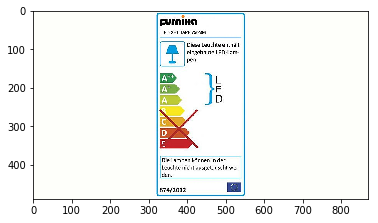

Sonstige
**
[{'probabilities': [0.0013441686751320958, 0.0035094195045530796, 0.0025952684227377176, 0.0005896514630876482, 1.3849351665484733e-09, 0.9919615387916565], 'classes': 5}]
[0.0013441686751320958, 0.0035094195045530796, 0.0025952684227377176, 0.0005896514630876482, 1.3849351665484733e-09, 0.9919615387916565]
{'probabilities': [0.0013441686751320958, 0.0035094195045530796, 0.0025952684227377176, 0.0005896514630876482, 1.3849351665484733e-09, 0.9919615387916565], 'classes': 5}
5


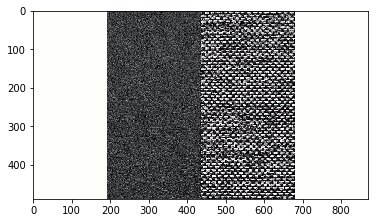

Zweifarbig
**
[{'probabilities': [0.6218740940093994, 0.3773082196712494, 8.251206600107253e-05, 0.000689599895849824, 7.598265483466093e-07, 4.491569779929705e-05], 'classes': 0}]
[0.6218740940093994, 0.3773082196712494, 8.251206600107253e-05, 0.000689599895849824, 7.598265483466093e-07, 4.491569779929705e-05]
{'probabilities': [0.6218740940093994, 0.3773082196712494, 8.251206600107253e-05, 0.000689599895849824, 7.598265483466093e-07, 4.491569779929705e-05], 'classes': 0}
0


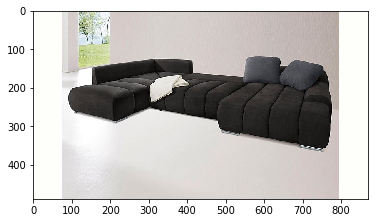

Ambiente
**
[{'probabilities': [5.474933839622054e-10, 1.6099185318196874e-09, 0.0026738655287772417, 0.9973251819610596, 8.542925617133559e-14, 9.814865506996284e-07], 'classes': 3}]
[5.474933839622054e-10, 1.6099185318196874e-09, 0.0026738655287772417, 0.9973251819610596, 8.542925617133559e-14, 9.814865506996284e-07]
{'probabilities': [5.474933839622054e-10, 1.6099185318196874e-09, 0.0026738655287772417, 0.9973251819610596, 8.542925617133559e-14, 9.814865506996284e-07], 'classes': 3}
3


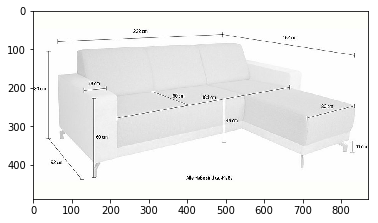

Sonstige
**
[{'probabilities': [1.4439501683227718e-06, 1.950892283275607e-06, 0.0217538271099329, 9.634141315473244e-05, 7.417175901247575e-11, 0.9781463742256165], 'classes': 5}]
[1.4439501683227718e-06, 1.950892283275607e-06, 0.0217538271099329, 9.634141315473244e-05, 7.417175901247575e-11, 0.9781463742256165]
{'probabilities': [1.4439501683227718e-06, 1.950892283275607e-06, 0.0217538271099329, 9.634141315473244e-05, 7.417175901247575e-11, 0.9781463742256165], 'classes': 5}
5


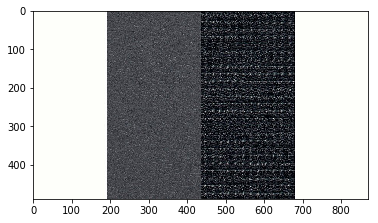

Zweifarbig
**
[{'probabilities': [0.6070014834403992, 0.3841804265975952, 0.002648791531100869, 0.0057035996578633785, 9.211596989189275e-06, 0.00045652431435883045], 'classes': 0}]
[0.6070014834403992, 0.3841804265975952, 0.002648791531100869, 0.0057035996578633785, 9.211596989189275e-06, 0.00045652431435883045]
{'probabilities': [0.6070014834403992, 0.3841804265975952, 0.002648791531100869, 0.0057035996578633785, 9.211596989189275e-06, 0.00045652431435883045], 'classes': 0}
0


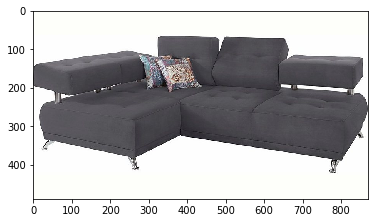

Freisteller
**
[{'probabilities': [2.567286117027834e-07, 4.409875145938713e-06, 0.9976147413253784, 0.00018946643103845417, 1.226446721958041e-10, 0.002191194798797369], 'classes': 2}]
[2.567286117027834e-07, 4.409875145938713e-06, 0.9976147413253784, 0.00018946643103845417, 1.226446721958041e-10, 0.002191194798797369]
{'probabilities': [2.567286117027834e-07, 4.409875145938713e-06, 0.9976147413253784, 0.00018946643103845417, 1.226446721958041e-10, 0.002191194798797369], 'classes': 2}
2


In [26]:
pictures = ['12812786.jpg', '13369544.jpg', '15452981.jpg', '16527635.jpg', '19103367.jpg', '20087011.jpg']

for picture in pictures:
    plot_and_predict_from_GS(picture)

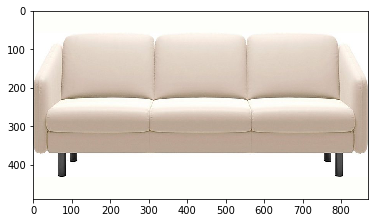

Freisteller


In [6]:
import wget
url = 'https://i.cnouch.de/i/otto/26923856.jpg?$ads_product_new$'
    
path = wget.download(url, ('/home/jupyter/' + PROJECT + '/local_test/pictures/'))

plot_and_predict_from_Local(path)

In [28]:
plot_and_predict_from_URL('https://i.cnouch.de/i/otto/28333726/Jockenhoefer-Gruppe-Schlafsofa-inkl-Bettkasten-28333726.jpg?maxW=998&maxH=562')

HttpError: <HttpError 400 when requesting https://ml.googleapis.com/v1/projects/bq-mak-yourhome/models/project_001_freisteller/versions/ResNet_v03:predict?alt=json returned "Request payload size exceeds the limit: 1572864 bytes.">